In [16]:
import numpy as np
import gzip
import theano
from keras.models import load_model
from keras.models import Model
import tensorflow as tf

import matplotlib.pyplot as plt
import pickle

In [17]:
def get_test():
    
    f = open('datasetTranskay/cb513+profile_split1.npy.gz', 'rb')
    cb513 = np.load(f)
    cb513 = np.reshape(cb513, (514, 700, 57))
    cb513 = cb513[:, :, :].astype(theano.config.floatX)

    return cb513

In [18]:
cb513 = get_test()

In [4]:
path = "allDataset_assembly/model-assmebly-2.hdf5"
m = load_model( path )

In [19]:
from IPython.display import clear_output
import random

allValidWindows = []
all_targets = []

for i in range(cb513.shape[0]):
    
    print("protein nr " ,i)
    clear_output(wait=True)
    
    lastIndex = 700
    #ground truth
    for k in range(700):
        ground_truth = cb513[i,k,22:30]
        if(ground_truth.sum() == 0):
            lastIndex = k
            break
        all_targets.append(ground_truth)

    #creating padding version so we do not loose information
    padded = np.zeros((700+18, 57))
    padded[9:709] = cb513[i]
    
    for k in range(9):
        #padded[8-k] = cb513[i, lastIndex - 1 - k]
        padded[k] = cb513[i,0]#cb513[i,random.randint(0, lastIndex - 1)]#  #0# #
    
    nexta = 0
    for k in range(lastIndex + 9 , lastIndex + 9 + 9):
        #padded[k] = cb513[i, 0 + nexta]
        nexta += 1
        padded[k] = 0#cb513[i,lastIndex - 1]##cb513[i,random.randint(0, lastIndex - 1)]#c
        
    
    #making predictions
    predictions = []
    for k in range(718 - 19 + 1):

        if cb513[i,k,0:21].sum() == 0:
            break
        #make sure to check PSSM or 1 hot
        window =  padded[k:k+19, 35:56]
        allValidWindows.append(window)

protein nr  513


In [6]:
scores = m.evaluate(np.array(allValidWindows), np.array(all_targets))
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

84765/84765 [==============================] - 58s 687us/step
Loss: 0.8752022515093971, Accuracy: 0.7006547451019287, MAE: 0.09288923442363739


In [5]:
from sklearn.metrics import accuracy_score
def get_accuracy(all_targets, all_pred ):
    
    all_targets = np.array(all_targets)

    final_pred = []
    final_target = []
    for i in range(len(allValidWindows)):
        final_pred.append( np.argmax(all_pred[i]))
        final_target.append( np.argmax(all_targets[i]))
        
    res = accuracy_score(final_pred, np.array(final_target))     
    print(res)
    return res

In [6]:
def sum_predictions(window_preds):
    return sum(window_preds, 0)
def average_predictions(window_preds):
    return np.average(window_preds, 0)
def max_predictions(window_preds):
    return np.max(window_preds, 0)

In [11]:
## model assembly cb513 accuracy
def get_stacked_predictions(allValidWindows, nr_models):
    
    stacked_predictions = []

    for i in range (0,nr_models):
    
        path = 'allDataset_assembly/model-assmebly-' + str(i) + '.hdf5'
        m = load_model( path )
        print("model " , i)
        predictions  = m.predict(allValidWindows, verbose = 1)
        acc = get_accuracy(all_targets, np.array(predictions) )

        stacked_predictions.append((predictions,acc))
        
    return stacked_predictions


In [ ]:
nr_models = 16
allValidWindows = np.array(allValidWindows)
stacked_predictions = get_stacked_predictions(allValidWindows, nr_models)

In [ ]:
##sorting the results descending of accuracy
stacked_predictions.sort(key = lambda t: t[1])
stacked_predictions.reverse()

In [ ]:
import pickle
#saving stacked predictins for further use
with open('allDataset_assembly/stacked_predictions-20', 'wb') as file_pi:
        pickle.dump(stacked_predictions, file_pi)       

In [9]:
stacked_predictions = pickle.load( open( "allDataset_assembly/stacked_predictions-20", "rb" ) )
stacked_predictions = np.array( [i[0] for i in stacked_predictions] )
#print(stacked_predictions)

In [12]:
def get_assembly_pred(stacked_predictions, models_picked):
    
    assembly_pred = []    
    for i in range(stacked_predictions.shape[1]):
        #print("window nr " ,i)
        #clear_output(wait=True)
    
        window_preds = stacked_predictions[models_picked,i]
        window_pred = average_predictions(window_preds)
        assembly_pred.append(window_pred)
     
    acc = get_accuracy(all_targets,  np.array(assembly_pred)  )
    return acc

In [13]:
acc_progress = []
models_picked = []
maxAcc = 0

final_indices = []

for i in range(20):
    
    models_picked.append(i)
    current = get_assembly_pred(stacked_predictions, models_picked)
    if current > maxAcc:
        maxAcc = current
        print(maxAcc, " ***")
        acc_progress.append(maxAcc)
        
        #saving the indices of the  models that hav been picked 
        final_indices = models_picked
    else:
        del models_picked[-1]
    

0.7006547513714387
0.7006547513714387  ***
0.705055152480387
0.705055152480387  ***
0.7072612516958651
0.7072612516958651  ***
0.7082758213885448
0.7082758213885448  ***
0.7080280776263788
0.7081106588804341
0.7082758213885448
0.7086533356927978
0.7086533356927978  ***
0.7096797027074854
0.7096797027074854  ***
0.709974635757683
0.709974635757683  ***
0.7104465286379992
0.7104465286379992  ***
0.7104465286379992
0.7105762991800861
0.7105762991800861  ***
0.7102695688078806
0.7104937179260308
0.7101397982657937
0.7106470831121335
0.7106470831121335  ***
0.710222379519849
0.7103049607739044
0.7103757447059518


In [15]:
with open('allDataset_assembly/supervised-assembly-indices', 'wb') as file_pi:
        pickle.dump(final_indices, file_pi)  

In [ ]:
#0.7101751902318174
fig1, ax1 = plt.subplots()
fig1.set_size_inches(7,4)

from matplotlib.ticker import MaxNLocator

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))



ax1.tick_params(labelsize=18)
ax1.set_ylabel("Q8 Accuracy on CB513", fontsize=20, labelpad=25, weight='bold')
ax1.set_xlabel("Number of models in assembly",  fontsize=20, weight='bold')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)



plt.plot([i for i in range(10)], acc_progress, linewidth =5)

plt.plot( np.array(acc_progress).argmax(), max(acc_progress), color = 'red', marker='x',markersize=10 , label = "Maximum Accuracy " + str(max(acc_progress))[:6] )

legend = ax1.legend(loc=0, fontsize='xx-large', fancybox=True)
plt.savefig("perf assembly plot", bbox_inches = 'tight')

In [ ]:
# 0.707756739220197 - 4 models all dataset - average
# 0.7093021884032324 - 12 models all dataset - average
# 0.7042883265498732 - 2 models all dataset - average
# 0.7093729723352798 - 16 models all dataset - average - with 30 epochs
# 0.7095027428773668 - 16 models all dataset - average - with 75 epochs

#0.707391022237952 -  15 models with valid split
# 0.7066949802394856 - 4 models with valid split


#0.7091842151831534 all 24

In [ ]:

m1H1 = pickle.load( open( "model-42f-hist-45epochs-0", "rb" ) )
# Plot training & validation accuracy values

a = np.array(m1H1['val_acc'])
inde = np.argmax(a)
x = m1H1['val_acc'][inde]
print(inde, " ", x)


plt.plot(m1H1['acc'])
plt.plot(m1H1['val_acc'])


In [ ]:
plt.plot(m1H1['loss'])
plt.plot(m1H1['val_loss'])

30.0


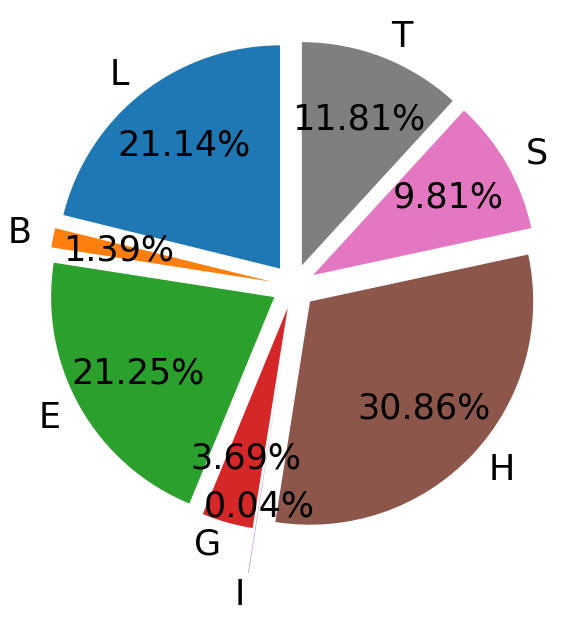

In [29]:

## displaying the distribution of the test set
sizes = np.zeros(8)
for i in range(cb513.shape[0]):
    for j in range(cb513.shape[1]):
        if cb513[i,j,22:30].sum() != 0:
            index = cb513[i,j,22:30].argmax()
            sizes[index] += 1
        
print(sizes[4])
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T'
explode = (0.1, 0.1, 0.1, 0.1, 0.3, 0.1,0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,15)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance  = 0.7, textprops={'fontsize': 35})

#plt.legend( prop={'size': 13})

plt.savefig("cb513pie", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()